In [2]:
import importlib.util

package_name = 'trimesh'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install trimesh
else:
    print(package_name +" is installed")
    
package_name = 'mahotas'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install mahotas
else:
    print(package_name +" is installed")
    


trimesh is installed
mahotas is installed


In [3]:
import numpy as np
import math
import cv2
import os
import pandas as pd
import mahotas
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import regionprops
from skimage.transform import rescale, resize
from skimage.morphology import thin
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
from matplotlib.ticker import MultipleLocator
from utils import dataset_loader, my_utils, Operations, Moments, generate_point_cloud
import warnings
warnings.filterwarnings('ignore')

from plyfile import PlyData, PlyElement
from itertools import product, combinations 

In [4]:
%matplotlib inline

Here we process the original data, if you want to analyze the generated samples, please scroll down 

# 0 Normalize the point cloud

In [5]:
def calc_mue(M):
    """
     Args:
         M: point cloud
    returns mean of a point cloud
    """
    return np.mean(M, axis=0)

def calc_dist(p, mue): 
    """    
    At first, minus mue from point clouds, then calculate square 2 of them
     Args:
         p:   point cloud
         mue: mean of point cloud
    
    returns: calculated distance
    """
    return np.linalg.norm(p-mue, 2)

def norm_points(DATA, do_normalize):
    processed_points = []      
    points  = DATA
    confidence = 0.95

    if do_normalize:
        Inlaier_points = []
        mue            = calc_mue(points)# cal mean of a point cloud
    #     print(mue.shape)
    #     print('mue', mue)
        sorted_dists   = sorted([calc_dist(p, mue) for p in points])
        XY             = [(0, 0)]
        t              = len(sorted_dists)
        for j, d in enumerate(sorted_dists):
            XY.append(( d, 1.*j/t ))
            if 1.*j/t >= confidence:
                break
        sorted_idx     = sorted([(i, my_utils.calc_dist(p, mue)) for i, p in enumerate(points)], key= lambda d:(d[1], d[0]))
        inlaier        = [d[0] for d in sorted_idx[:j]]
        inlaier_points = [points[j] for j in inlaier]
        points         = np.array(inlaier_points)
    #     print(points.shape)
        points        -= mue
    
    return points

## 1.1 Load .ply files

In [11]:
DATA_DIR    = 'D:\\forClone\\Hiwi\\Microgel\\16-FM\\lifetime'
sample_inx = 2

sample_file = str(sample_inx)+".ply"
sample_pth = os.path.join(DATA_DIR, sample_file)
print(sample_pth)

D:\forClone\Hiwi\Microgel\16-FM\lifetime\2.ply


## 1.2 open 3D

In [12]:
import open3d as o3d

pcd_load = o3d.io.read_point_cloud(sample_pth)
# o3d.visualization.draw_geometries([pcd_load])
# convert Open3D.o3d.geometry.PointCloud to numpy array
DATA = np.asarray(pcd_load.points)
DATA = DATA.astype(np.float)
print(type(DATA))
print(DATA.size)
do_normalize = True
DATA = norm_points(DATA, do_normalize)
print(type(DATA))
print(DATA.size)

<class 'numpy.ndarray'>
5463
<class 'numpy.ndarray'>
5190


# 2 Single point cloud visualization

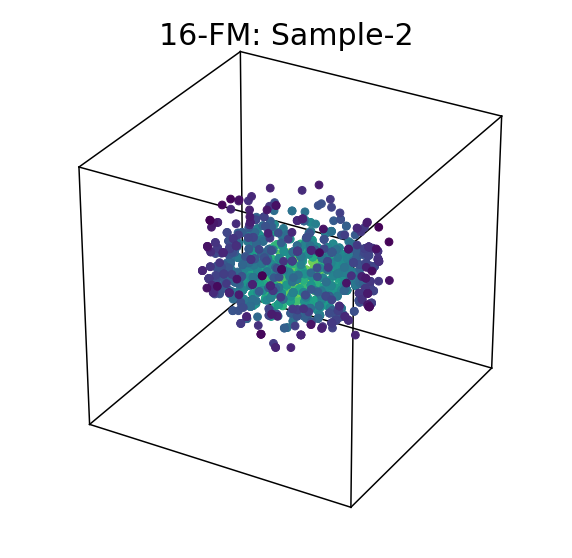

In [15]:
from itertools import product, combinations 
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
colors = ['g', 'b', 'k', 'y', 'm', 'c']
points = DATA
#     print(dataset_dict)
sample_per_class = 1
mue            = np.mean(DATA, axis=0)

dists   = [calc_dist(p, mue) for p in points]

dists = np.array(dists)
abs_dists = np.abs(dists)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, sample_per_class, 1, projection="3d")
cmap = mpl.cm.viridis
# https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
cmap = cmap.reversed()
# cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
# ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,cmap=cmap, alpha=1)
ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
ax1.set_xlabel('x / nm')
ax1.set_ylabel('y / nm')
ax1.set_zlabel('z / nm')
lm = 2.5
ax1.set_xlim((-lm,lm))
ax1.set_ylim((-lm,lm))
ax1.set_zlim((-lm,lm))

# draw cube
r = [-lm, lm]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
   if np.sum(np.abs(s-e)) == r[1]-r[0]:
      ax1.plot3D(*zip(s, e), color="k")

ax1.grid(False)
ax1.axis('off')
title_info = "16-FM: Sample-"+str(sample_inx)
ax1.set_title(title_info, fontsize=30)
plt.show()

# 3 Multiple Samples 

<class 'numpy.ndarray'>
6306
<class 'numpy.ndarray'>
5991
<class 'numpy.ndarray'>
5463
<class 'numpy.ndarray'>
5190
<class 'numpy.ndarray'>
4917
<class 'numpy.ndarray'>
4674
<class 'numpy.ndarray'>
5046
<class 'numpy.ndarray'>
4794
<class 'numpy.ndarray'>
5256
<class 'numpy.ndarray'>
4995
<class 'numpy.ndarray'>
5961
<class 'numpy.ndarray'>
5664


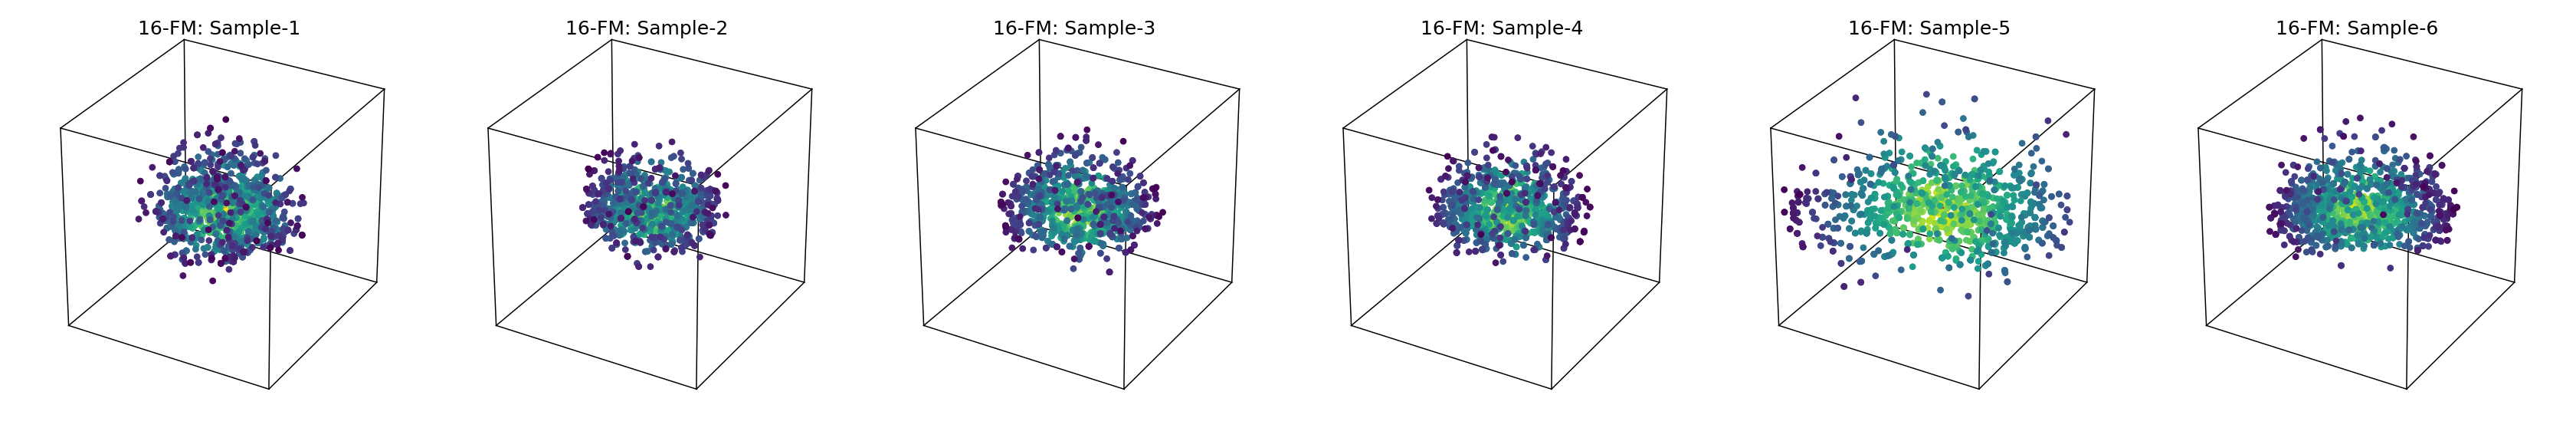

In [18]:
import open3d as o3d
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
DATA_DIR    = 'D:\\forClone\\Hiwi\\Microgel\\16-FM\\lifetime'
data_type = '16FM' #'_go' or 'gg'
for tmp_inx in range(1,2):

    fig = plt.figure(figsize=(60,10))
    for sample_inx in range(1,7):
        # sample_inx = 1
        sample_file = str(sample_inx)+".ply"
        sample_pth = os.path.join(DATA_DIR, sample_file)
        pcd_load = o3d.io.read_point_cloud(sample_pth)
        # o3d.visualization.draw_geometries([pcd_load])
        # convert Open3D.o3d.geometry.PointCloud to numpy array
        DATA = np.asarray(pcd_load.points)
        DATA = DATA.astype(np.float)
        print(type(DATA))
        print(DATA.size)
        do_normalize = True
        DATA = norm_points(DATA, do_normalize)
        print(type(DATA))
        print(DATA.size)

        colors = ['g', 'b', 'k', 'y', 'm', 'c']
        points = DATA
        #     print(dataset_dict)
        sample_per_class = 1
        mue            = np.mean(DATA, axis=0)

        dists   = [calc_dist(p, mue) for p in points]

        dists = np.array(dists)
        abs_dists = np.abs(dists)
        ax1 = fig.add_subplot(1, 6, sample_inx, projection="3d")
        cmap = mpl.cm.viridis
        # https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
        cmap = cmap.reversed()
        # cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
        # ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,cmap=cmap, alpha=1)
        ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
        ax1.set_xlabel('x / nm')
        ax1.set_ylabel('y / nm')
        ax1.set_zlabel('z / nm')
        lm=2.5
        ax1.set_xlim((-lm,lm))
        ax1.set_ylim((-lm,lm))
        ax1.set_zlim((-lm,lm))

        # draw cube
        r = [-lm, lm]
        for s, e in combinations(np.array(list(product(r, r, r))), 2):
           if np.sum(np.abs(s-e)) == r[1]-r[0]:
              ax1.plot3D(*zip(s, e), color="k")

        ax1.grid(False)
        ax1.axis('off')
        title_info = "16-FM: Sample-"+str(sample_inx)
        ax1.set_title(title_info, fontsize=25)
    
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()
    fig.savefig(DATA_DIR+'3d_'+data_type+'.pdf', bbox_inches='tight')

Here we process the generated data

# 0 Normalize the point cloud

In [7]:
def calc_mue(M):
    """
     Args:
         M: point cloud
    returns mean of a point cloud
    """
    return np.mean(M, axis=0)

def calc_dist(p, mue): 
    """    
    At first, minus mue from point clouds, then calculate square 2 of them
     Args:
         p:   point cloud
         mue: mean of point cloud
    
    returns: calculated distance
    """
    return np.linalg.norm(p-mue, 2)

def norm_points(DATA, do_normalize):
    processed_points = []      
    points  = DATA
    confidence = 0.95

    if do_normalize:
        Inlaier_points = []
        mue            = calc_mue(points)# cal mean of a point cloud
    #     print(mue.shape)
    #     print('mue', mue)
        sorted_dists   = sorted([calc_dist(p, mue) for p in points])
        XY             = [(0, 0)]
        t              = len(sorted_dists)
        for j, d in enumerate(sorted_dists):
            XY.append(( d, 1.*j/t ))
            if 1.*j/t >= confidence:
                break
        sorted_idx     = sorted([(i, my_utils.calc_dist(p, mue)) for i, p in enumerate(points)], key= lambda d:(d[1], d[0]))
        inlaier        = [d[0] for d in sorted_idx[:j]]
        inlaier_points = [points[j] for j in inlaier]
        points         = np.array(inlaier_points)
    #     print(points.shape)
        points        -= mue
    
    return points


def preprocess(p, info):
    p = p  * (info[1,:]-info[2,:]) + info[2,:]+ info[0,:]
    p = p[:,:3]
    
    return p

def cal_hull_dist(DATA, REAL):
    dist_array=np.zeros((len(DATA), len(REAL)))
    for i_d, d in enumerate(DATA):
        for ir, r in enumerate(REAL):
            dist_array[i_d, ir] = calc_dist(d, r) 
    return dist_array

# 1 Single Visualization
## 1.1 Load .ply files (but not point cloud file)

In [6]:
DATA_DIR    = 'D:\\forClone\\Hiwi\\Microgel\\16-FM\\results_lifetime'
sample_inx = 2
sample_type = ['gg', 'go']

sample_file = "sample_"+sample_type[0]+str(sample_inx)+".ply"
sample_pth = os.path.join(DATA_DIR, sample_file)
info_file = "sample_"+"info"+str(sample_inx)+".ply"
info_pth = os.path.join(DATA_DIR, info_file)
print(sample_pth)
print(info_pth)

D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_gg2.ply
D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_info2.ply


## 1.2 preprocess data with info file

In [9]:
DATA = pd.read_csv(sample_pth, delimiter = "\t", header=None)
DATA = DATA.to_numpy()
INFO = pd.read_csv(info_pth, delimiter = "\t", header=None)
INFO = INFO.to_numpy()
DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
DATA = DATA[:,:3]#only extract the location information
DATA[:,2] = 1-DATA[:,2]
print(type(DATA))
print(DATA.size)
DATA = DATA.astype(np.float)
do_normalize = True
DATA = norm_points(DATA, do_normalize)
print(type(DATA))
print(DATA.size)

<class 'numpy.ndarray'>
4869
<class 'numpy.ndarray'>
4626


## 1.3 Single Visualization

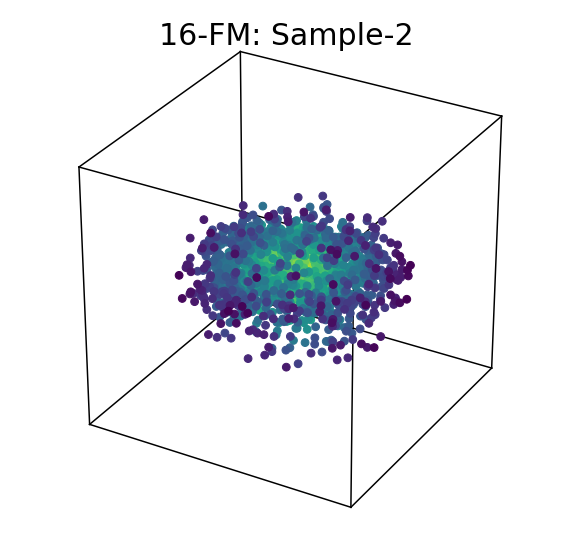

In [10]:
from itertools import product, combinations 
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
colors = ['g', 'b', 'k', 'y', 'm', 'c']
points = DATA
#     print(dataset_dict)
sample_per_class = 1
mue            = np.mean(DATA, axis=0)

dists   = [calc_dist(p, mue) for p in points]

dists = np.array(dists)
abs_dists = np.abs(dists)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, sample_per_class, 1, projection="3d")
cmap = mpl.cm.viridis
# https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
cmap = cmap.reversed()
# cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
# ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,cmap=cmap, alpha=1)
ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
ax1.set_xlabel('x / nm')
ax1.set_ylabel('y / nm')
ax1.set_zlabel('z / nm')
lm = 2.5
ax1.set_xlim((-lm,lm))
ax1.set_ylim((-lm,lm))
ax1.set_zlim((-lm,lm))

# draw cube
r = [-lm, lm]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
   if np.sum(np.abs(s-e)) == r[1]-r[0]:
      ax1.plot3D(*zip(s, e), color="k")

ax1.grid(False)
ax1.axis('off')
title_info = "16-FM: Sample-"+str(sample_inx)
ax1.set_title(title_info, fontsize=30)
plt.show()

# 2 Multiple Samples 

5409
5139
4869
4626
5904
5610
5904
5610
5409
5139
4869
4626


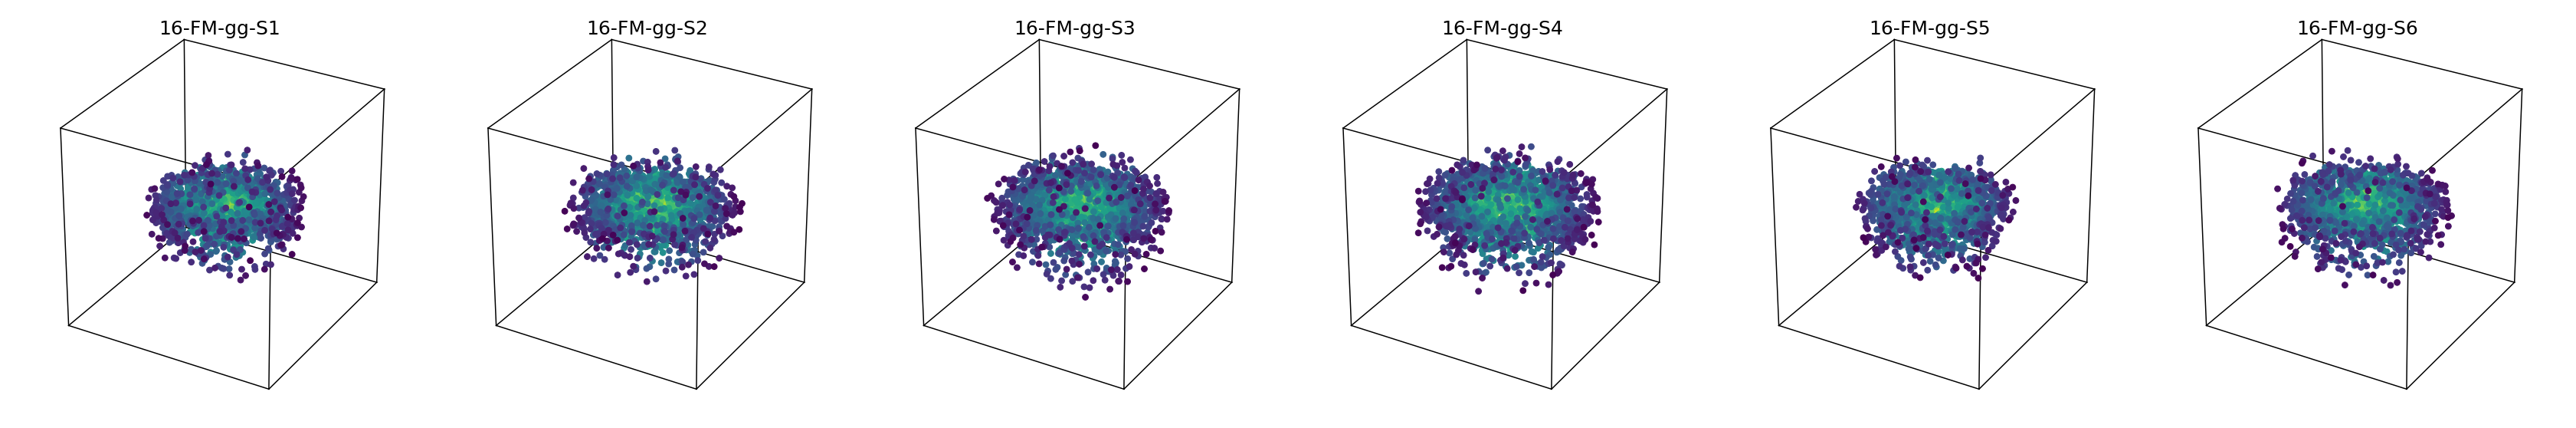

5463
5190
4917
4674
5961
5664
5961
5664
5463
5190
4917
4674


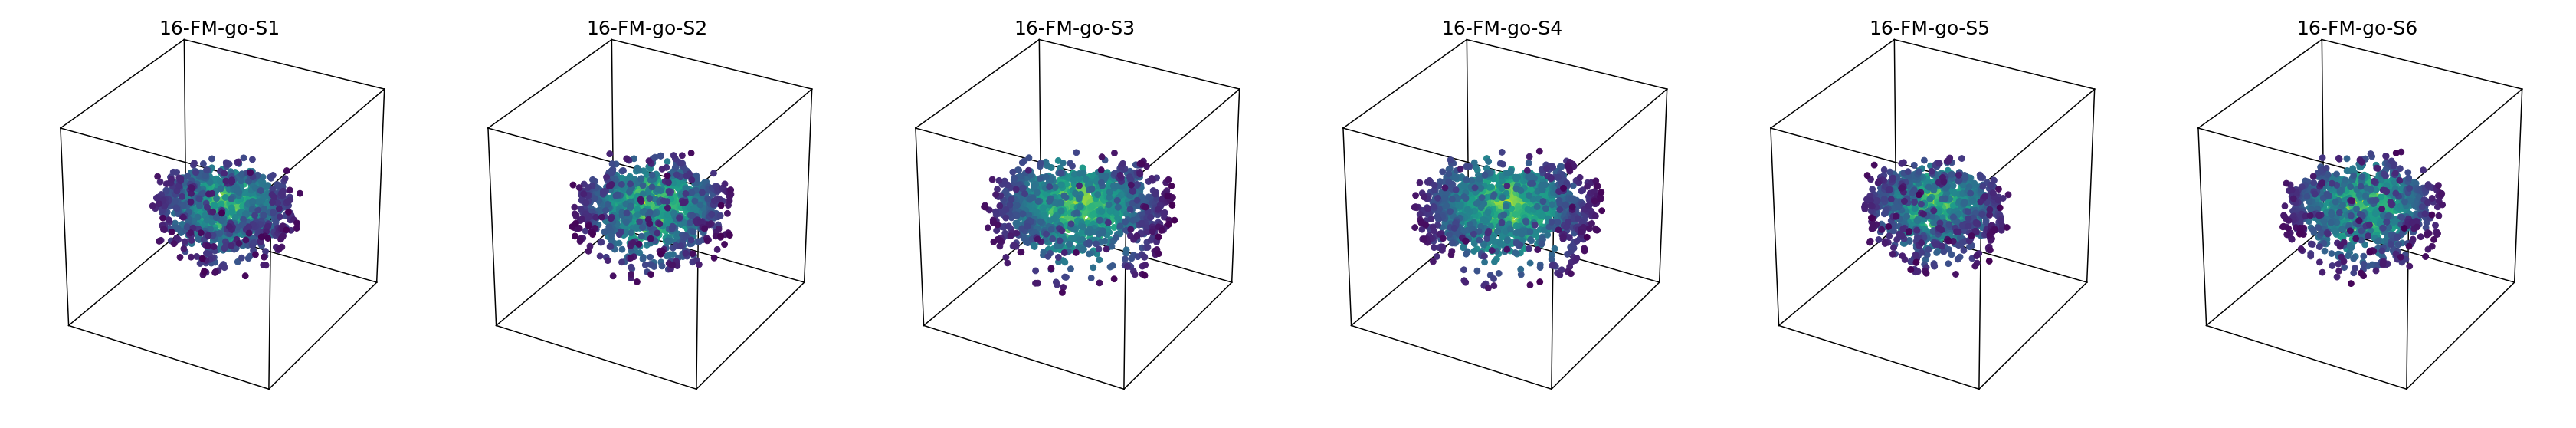

In [12]:
import open3d as o3d
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
DATA_DIR    = 'D:\\forClone\\Hiwi\\Microgel\\16-FM\\results_lifetime'
data_type = '16FM' #'_go' or 'gg'
sample_type = ['gg', 'go']
for tmp_inx in range(2):

    fig = plt.figure(figsize=(60,10))
    for sample_inx in range(1,7):
        # sample_inx = 1
        sample_file = "sample_"+sample_type[tmp_inx]+str(sample_inx)+".ply"
        sample_pth = os.path.join(DATA_DIR, sample_file)
        info_file = "sample_"+"info"+str(sample_inx)+".ply"
        info_pth = os.path.join(DATA_DIR, info_file)
        
        DATA = pd.read_csv(sample_pth, delimiter = "\t", header=None)
        DATA = DATA.to_numpy()
        INFO = pd.read_csv(info_pth, delimiter = "\t", header=None)
        INFO = INFO.to_numpy()
        DATA  = DATA  * (INFO[1,:]-INFO[2,:]) + INFO[2,:]+ INFO[0,:];
        DATA = DATA[:,:3]#only extract the location information
        DATA[:,2] = 1-DATA[:,2]
        print(DATA.size)
        DATA = DATA.astype(np.float)
        do_normalize = True
        DATA = norm_points(DATA, do_normalize)
        print(DATA.size)

        colors = ['g', 'b', 'k', 'y', 'm', 'c']
        points = DATA
        #     print(dataset_dict)
        sample_per_class = 1
        mue            = np.mean(DATA, axis=0)

        dists   = [calc_dist(p, mue) for p in points]

        dists = np.array(dists)
        abs_dists = np.abs(dists)
        ax1 = fig.add_subplot(1, 6, sample_inx, projection="3d")
        cmap = mpl.cm.viridis
        # https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
        cmap = cmap.reversed()
        # cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
        # ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,cmap=cmap, alpha=1)
        ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
        ax1.set_xlabel('x / nm')
        ax1.set_ylabel('y / nm')
        ax1.set_zlabel('z / nm')
        lm=2.5
        ax1.set_xlim((-lm,lm))
        ax1.set_ylim((-lm,lm))
        ax1.set_zlim((-lm,lm))

        # draw cube
        r = [-lm, lm]
        for s, e in combinations(np.array(list(product(r, r, r))), 2):
            if np.sum(np.abs(s-e)) == r[1]-r[0]:
                ax1.plot3D(*zip(s, e), color="k")

        ax1.grid(False)
        ax1.axis('off')
        title_info = "16-FM-"+sample_type[tmp_inx]+"-S"+str(sample_inx)
        ax1.set_title(title_info, fontsize=25)
    
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()
    fig.savefig(DATA_DIR+'\\visual3d\\3d_'+sample_type[tmp_inx]+'.pdf', bbox_inches='tight')

# 3 Convex Hull Distance

In [36]:
def preprocess(p, info):
    p = p  * (info[1,:]-info[2,:]) + info[2,:]+ info[0,:];
    p = p[:,:3]
    
    return p

def cal_hull_dist(DATA, REAL):
    dist_array=np.zeros((len(DATA), len(REAL)))
    for i_d, d in enumerate(DATA):
        for ir, r in enumerate(REAL):
            dist_array[i_d, ir] = calc_dist(d, r) 
    return dist_array

In [55]:
DATA_DIR    = 'D:\\forClone\\Hiwi\\Microgel\\16-FM\\results_lifetime'
sample_inx = 1
sample_type = ['gg', 'go']

sample_file = "sample_"+sample_type[0]+str(sample_inx)+".ply"
sample_pth = os.path.join(DATA_DIR, sample_file)
info_file = "sample_"+"info"+str(sample_inx)+".ply"
info_pth = os.path.join(DATA_DIR, info_file)
real_file = "sample_"+sample_type[1]+str(sample_inx)+".ply"
real_pth = os.path.join(DATA_DIR, real_file)
print(sample_pth)
print(info_pth)
print(real_pth)

DATA = pd.read_csv(sample_pth, delimiter = "\t", header=None)
DATA = DATA.to_numpy()
REAL = pd.read_csv(real_pth, delimiter = "\t", header=None)
REAL = REAL.to_numpy()
INFO = pd.read_csv(info_pth, delimiter = "\t", header=None)
INFO = INFO.to_numpy()

DATA = preprocess(DATA, INFO)
DATA[:,2] = 1-DATA[:,2]
REAL = preprocess(REAL, INFO)
REAL[:,2] = 1-REAL[:,2]

print(type(DATA))
print(DATA.size)
DATA = DATA.astype(np.float)
do_normalize = True
DATA = norm_points(DATA, do_normalize)

print(type(REAL))
print(REAL.size)
REAL = REAL.astype(np.float)
do_normalize = True
REAL = norm_points(REAL, do_normalize)

print(type(DATA))
print(DATA.size)
print(type(REAL))
print(REAL.size)

D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_gg1.ply
D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_info1.ply
D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_go1.ply
<class 'numpy.ndarray'>
5409
<class 'numpy.ndarray'>
5463
<class 'numpy.ndarray'>
5139
<class 'numpy.ndarray'>
5190


3978521.331811842
0.0049053723681894675


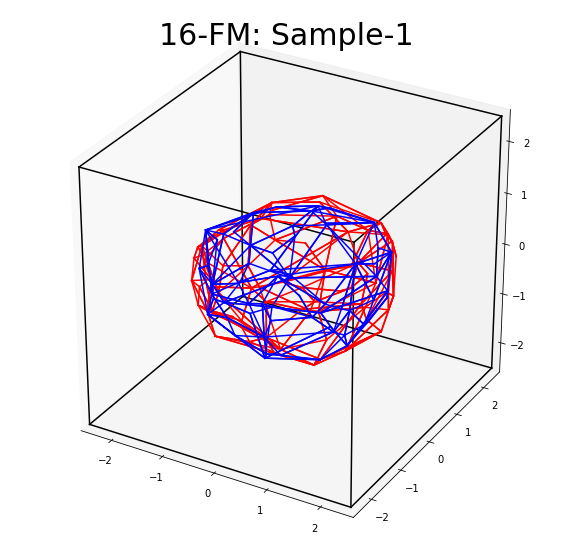

In [63]:
from itertools import product, combinations 
from scipy.spatial import ConvexHull
is_scatter = False
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
colors = ['g', 'b', 'k', 'y', 'm', 'c']
points = DATA
#     print(dataset_dict)
sample_per_class = 1
mue            = np.mean(DATA, axis=0)

dists   = [calc_dist(p, mue) for p in points]

dists = np.array(dists)
abs_dists = np.abs(dists)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, sample_per_class, 1, projection="3d")
cmap = mpl.cm.viridis
# https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
cmap = cmap.reversed()
# cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
# ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
# ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,cmap=cmap, alpha=1)
if is_scatter:
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=points[:, 2],cmap=cmap,vmin=-1, vmax=1, alpha=1)
    ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
    ax1.set_xlabel('x / nm')
    ax1.set_ylabel('y / nm')
    ax1.set_zlabel('z / lifetime')
lm = 2.5
ax1.set_xlim((-lm,lm))
ax1.set_ylim((-lm,lm))
ax1.set_zlim((-lm,lm))

# draw cube
r = [-lm, lm]
for s, e in combinations(np.array(list(product(r, r, r))), 2):  
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax1.plot3D(*zip(s, e), color="k")

# draw convex hull
hull_DATA = ConvexHull(DATA)
simplices_p=[]
for i in hull_DATA.simplices:
    ax1.plot(DATA[i,0], DATA[i,1], DATA[i,2], 'r-')
    simplices_p.append([DATA[i,0], DATA[i,1], DATA[i,2]])
hull_REAL = ConvexHull(REAL)
simplices_r=[]
for i in hull_REAL.simplices:
    ax1.plot(REAL[i,0], REAL[i,1], REAL[i,2], 'b-')
    simplices_r.append([REAL[i,0], REAL[i,1], REAL[i,2]]) 

dist_array = cal_hull_dist(np.array(simplices_p), np.array(simplices_r))
sum_dist = np.sum(np.array(dist_array))
# edges = list(zip(*points))
# ax1.plot(edges[0], edges[1], edges[2], 'bo')

# set axes
ax1.grid(False)
ax1.axis('on')
title_info = "16-FM: Sample-"+str(sample_inx)
ax1.set_title(title_info, fontsize=30)
plt.show()

In [64]:

# min_dist = np.minimum()
print(sum_dist)
print(np.amin(dist_array))

63662.97223000745
0.34181631511822314


## Multiple convex hull distance

5409
5139
<class 'numpy.ndarray'>
5463
4869
4626
<class 'numpy.ndarray'>
4917
5904
5610
<class 'numpy.ndarray'>
5961
5904
5610
<class 'numpy.ndarray'>
5961
5409
5139
<class 'numpy.ndarray'>
5463
4869
4626
<class 'numpy.ndarray'>
4917


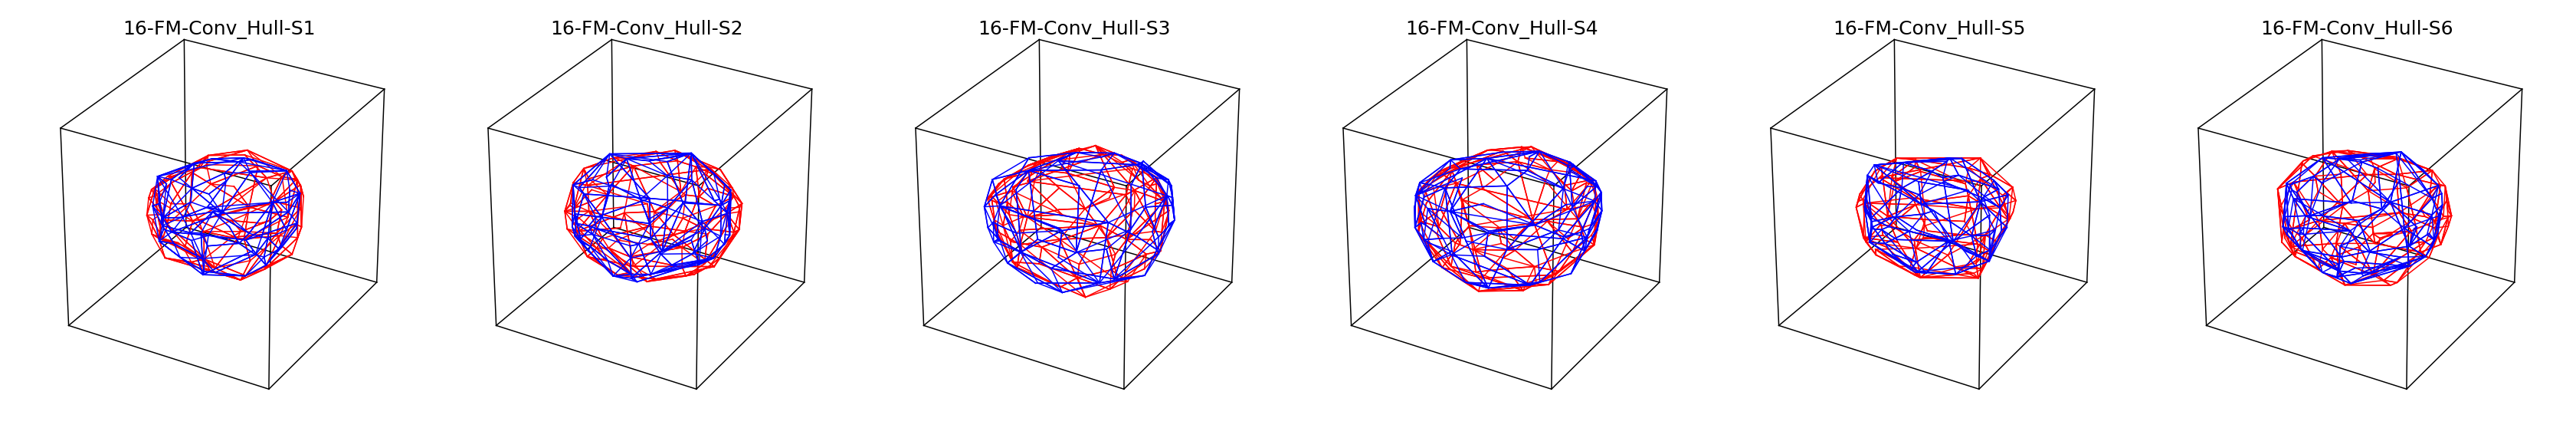

In [68]:
import open3d as o3d
# https://stackoverflow.com/questions/15053575/python-3d-scatterplot-colormap-issue
# https://matplotlib.org/stable/tutorials/colors/colorbar_only.html#sphx-glr-tutorials-colors-colorbar-only-py
DATA_DIR    = 'D:\\forClone\\Hiwi\\Microgel\\16-FM\\results_lifetime'
data_type = '16FM' #'_go' or 'gg'
sample_type = ['gg', 'go']
is_scatter = False
sum_dist=[]
for tmp_inx in range(1):

    fig = plt.figure(figsize=(60,10))
    for sample_inx in range(1,7):
        # sample_inx = 1
        sample_file = "sample_"+sample_type[0]+str(sample_inx)+".ply"
        sample_pth = os.path.join(DATA_DIR, sample_file)
        info_file = "sample_"+"info"+str(sample_inx)+".ply"
        info_pth = os.path.join(DATA_DIR, info_file)
        real_file = "sample_"+sample_type[1]+str(sample_inx)+".ply"
        real_pth = os.path.join(DATA_DIR, real_file)
        
        DATA = pd.read_csv(sample_pth, delimiter = "\t", header=None)
        DATA = DATA.to_numpy()
        REAL = pd.read_csv(real_pth, delimiter = "\t", header=None)
        REAL = REAL.to_numpy()
        INFO = pd.read_csv(info_pth, delimiter = "\t", header=None)
        INFO = INFO.to_numpy()
        DATA = preprocess(DATA, INFO)
        DATA[:,2] = 1-DATA[:,2]
        REAL = preprocess(REAL, INFO)
        REAL[:,2] = 1-REAL[:,2]
        
        print(DATA.size)
        DATA = DATA.astype(np.float)
        do_normalize = True
        DATA = norm_points(DATA, do_normalize)
        print(DATA.size)

        print(type(REAL))
        print(REAL.size)
        REAL = REAL.astype(np.float)
        do_normalize = True
        REAL = norm_points(REAL, do_normalize)

        colors = ['g', 'b', 'k', 'y', 'm', 'c']
        points = DATA
        #     print(dataset_dict)
        sample_per_class = 1
        mue            = np.mean(DATA, axis=0)

        dists   = [calc_dist(p, mue) for p in points]

        dists = np.array(dists)
        abs_dists = np.abs(dists)
        ax1 = fig.add_subplot(1, 6, sample_inx, projection="3d")
        cmap = mpl.cm.viridis
        # https://www.geeksforgeeks.org/how-to-reverse-a-colormap-using-matplotlib-in-python/
        cmap = cmap.reversed()
        # cmap_norm =  mpl.colors.Normalize(vmin=0, vmax=0.45)
        # ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=colors[1],marker="o", facecolor="red", lw=0, alpha=1)
        if is_scatter:
            ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=60, c=abs_dists,cmap=cmap, alpha=1)
            ax1.scatter(mue[0], mue[1], mue[2], s=200, c='r', marker="*")
            ax1.set_xlabel('x / nm')
            ax1.set_ylabel('y / nm')
            ax1.set_zlabel('z / nm')
            
        lm=2.5
        ax1.set_xlim((-lm,lm))
        ax1.set_ylim((-lm,lm))
        ax1.set_zlim((-lm,lm))

        # draw cube
        r = [-lm, lm]
        for s, e in combinations(np.array(list(product(r, r, r))), 2):
            if np.sum(np.abs(s-e)) == r[1]-r[0]:
                ax1.plot3D(*zip(s, e), color="k")

        ax1.grid(False)
        ax1.axis('off')
        title_info = "16-FM-"+"Conv_Hull"+"-S"+str(sample_inx)
        ax1.set_title(title_info, fontsize=25)
        
        
        # draw convex hull
        hull_DATA = ConvexHull(DATA)
        simplices_p=[]
        for i in hull_DATA.simplices:
            ax1.plot(DATA[i,0], DATA[i,1], DATA[i,2], 'r-')
            simplices_p.append([DATA[i,0], DATA[i,1], DATA[i,2]])
        hull_REAL = ConvexHull(REAL)
        simplices_r=[]
        for i in hull_REAL.simplices:
            ax1.plot(REAL[i,0], REAL[i,1], REAL[i,2], 'b-')
            simplices_r.append([REAL[i,0], REAL[i,1], REAL[i,2]]) 

        dist_array = cal_hull_dist(np.array(simplices_p), np.array(simplices_r))
        sum_dist.append(np.sum(np.array(dist_array)))
    
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()
    fig.savefig(DATA_DIR+'\\visual_conv_hull\\conv_hull'+'.pdf', bbox_inches='tight')

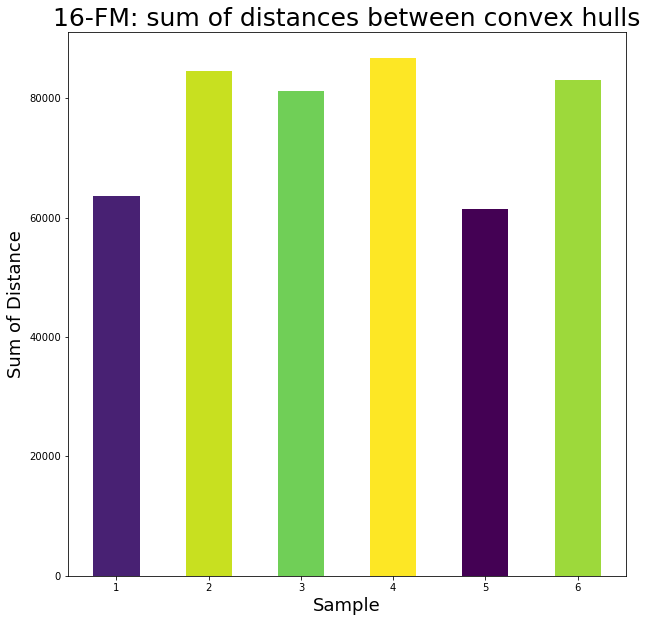

In [82]:
# print(sum_dist)


fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(1, 1, 1)
xaxis = range(1,7)
yaxis = np.array(sum_dist)
my_cmap = plt.get_cmap("viridis")
rescale = lambda yaxis: (yaxis - np.min(yaxis)) / (np.max(yaxis) - np.min(yaxis))
ax2.bar(xaxis,yaxis , width=0.5, color=my_cmap(rescale(yaxis)))
title_info_conv = "16-FM: "+"sum of distances between convex hulls"
ax2.set_title(title_info_conv, fontsize=25)
ax2.set_xlabel('Sample', fontsize=18)
ax2.set_ylabel('Sum of Distance', fontsize=18)

fig2.savefig(DATA_DIR+'\\visual_conv_hull\\conv_hull_distance'+'.pdf', bbox_inches='tight')


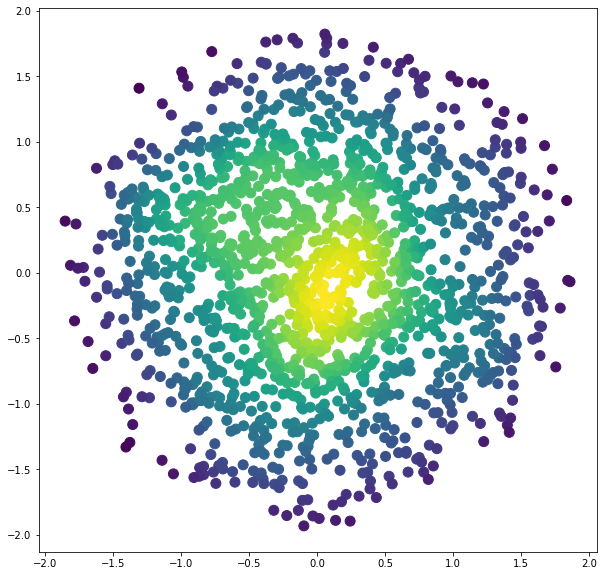

In [31]:
# 3 2D projection with density
# from scipy.stats import gaussian_kde

# xy = np.vstack([points[:, 0], points[:, 1]])
# z = gaussian_kde(xy)(xy)

# fig2 = plt.figure(figsize=(10,10))
# ax2 = fig2.add_subplot(1, 1, 1)
# ax2.scatter(points[:, 0], points[:, 1],c=z,s=100)
# ax2.grid(False)
# ax2.axis('on')
# plt.show()

# Correlation between localization and lifetime

In [9]:
DATA_DIR    = 'D:\\forClone\\Hiwi\\Microgel\\16-FM\\results_lifetime'
sample_inx = 1
sample_type = ['gg', 'go']

sample_file = "sample_"+sample_type[0]+str(sample_inx)+".ply"
sample_pth = os.path.join(DATA_DIR, sample_file)
info_file = "sample_"+"info"+str(sample_inx)+".ply"
info_pth = os.path.join(DATA_DIR, info_file)
real_file = "sample_"+sample_type[1]+str(sample_inx)+".ply"
real_pth = os.path.join(DATA_DIR, real_file)
print(sample_pth)
print(info_pth)
print(real_pth)

DATA = pd.read_csv(sample_pth, delimiter = "\t", header=None)
DATA = DATA.to_numpy()
REAL = pd.read_csv(real_pth, delimiter = "\t", header=None)
REAL = REAL.to_numpy()
INFO = pd.read_csv(info_pth, delimiter = "\t", header=None)
INFO = INFO.to_numpy()

DATA = preprocess(DATA, INFO)
DATA[:,2] = 1-DATA[:,2]
REAL = preprocess(REAL, INFO)
REAL[:,2] = 1-REAL[:,2]

print(type(DATA))
print(DATA.size)
DATA = DATA.astype(np.float)
do_normalize = True
DATA = norm_points(DATA, do_normalize)
print(type(DATA))
print(DATA.size)

print(type(REAL))
print(REAL.size)
REAL = REAL.astype(np.float)
do_normalize = True
REAL = norm_points(REAL, do_normalize)
print(type(REAL))
print(REAL.size)

D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_gg1.ply
D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_info1.ply
D:\forClone\Hiwi\Microgel\16-FM\results_lifetime\sample_go1.ply
<class 'numpy.ndarray'>
5409
<class 'numpy.ndarray'>
5139
<class 'numpy.ndarray'>
5463
<class 'numpy.ndarray'>
5190
